# Station Clustering (Winter 2018)
This notebook uses K-nearest neighbors and PCA to gorup stations into different types

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('./data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('./data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('./data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [3]:
subs_df[subs_df['start station latitude']>41]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bikeid, usertype, birth year, gender]
Index: []

In [4]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [5]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [6]:
weekend_subs_trips_df.head()

tripduration               starttime                stoptime  \
116          1347 2018-01-06 11:12:20.973 2018-01-06 11:34:48.773   
117           471 2018-01-06 11:43:53.488 2018-01-06 11:51:44.696   
118           304 2018-01-06 17:15:05.323 2018-01-06 17:20:09.783   
119           374 2018-01-07 12:42:24.651 2018-01-07 12:48:38.807   
120           334 2018-01-07 13:48:19.772 2018-01-07 13:53:54.086   

     start station id  end station id  bikeid    usertype  birth year  gender  \
116                72             382   18783  Subscriber        1968       1   
117                72             479   25288  Subscriber        1992       1   
118                72             515   32352  Subscriber        1974       1   
119                72             450   16988  Subscriber        1983       1   
120                72             173   31484  Subscriber        1977       1   

     start_day  stop_day  pickup_hour  dropoff_hour  age Trip_Type  \
116          5         5           11            11   50   Weekend   
117          5         5           11            11   26   Weekend   
118          5         5           17            17   44   Weekend   
119          6         6           12            12   35   Weekend   
120          6         6           13            13   41   Weekend   

    start_end_station  
116         (72, 382)  
117         (72, 479)  
118         (72, 515)  
119         (72, 450)  
120         (72, 173)

In [7]:
WD_puhour_groupby = weekday_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WD_puhour_df = WD_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WD_dohour_groupby = weekday_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WD_dohour_df = WD_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [8]:
WD_counts_df = pd.concat([WD_puhour_df,WD_dohour_df],axis=1).fillna(0)
WD_counts_df['total_pickups'] = WD_counts_df['NumPickups'].sum(axis=1)
WD_counts_df['total_dropoffs'] = WD_counts_df['NumDropoffs'].sum(axis=1)

In [9]:
for num in range(24):
    WD_counts_df['Activity',num] =  WD_counts_df['NumPickups',num] + WD_counts_df['NumDropoffs',num]
    WD_counts_df['Flux',num] =  WD_counts_df['NumPickups',num] - WD_counts_df['NumDropoffs',num]
WD_counts_df['total_counts'] = WD_counts_df['Activity'].sum(axis=1)

# Normalize by total activity for station -- maybe just do this right before clustering step?
for num in range(24):
    WD_counts_df['norm_Activity',num] =  WD_counts_df['Activity',num]/WD_counts_df['total_counts']
    WD_counts_df['norm_Flux',num] =  WD_counts_df['Flux',num]/WD_counts_df['total_counts']


In [10]:
WD_counts_df.sort_values('total_counts',ascending=False).head()

NumPickups                                                         \
pickup_hour         0     1     2     3     4      5       6       7       8    
519               74.0  45.0   8.0   6.0   4.0  284.0   692.0  1839.0  2760.0   
3255              38.0  31.0  10.0   6.0  65.0  194.0  2935.0  2823.0  2169.0   
402               34.0  18.0   7.0   9.0   7.0   23.0   132.0   332.0   616.0   
435               45.0  12.0   2.0   4.0  14.0   48.0   118.0   361.0   843.0   
490               68.0  23.0  19.0  20.0  94.0  332.0   773.0  1017.0  1547.0   

                       ...    norm_Activity norm_Flux norm_Activity norm_Flux  \
pickup_hour      9     ...               19        19            20        20   
519          2303.0    ...         0.071903  0.013217      0.029909  0.004688   
3255         1140.0    ...         0.039903 -0.004213      0.018872 -0.000445   
402           590.0    ...         0.063773  0.026796      0.024745  0.007636   
435           861.0    ...         0.062126  0.008248      0.040522  0.000719   
490          1065.0    ...         0.053266  0.000348      0.032369  0.002549   

            norm_Activity norm_Flux norm_Activity norm_Flux norm_Activity  \
pickup_hour            21        21            22        22            23   
519              0.015682  0.001010      0.008852  0.001253      0.004143   
3255             0.014865 -0.000343      0.011508  0.000959      0.006713   
402              0.013716  0.002899      0.009156  0.002156      0.003747   
435              0.027015  0.000681      0.009383  0.000908      0.006735   
490              0.024721  0.007416      0.022094  0.005408      0.008768   

            norm_Flux  
pickup_hour        23  
519          0.000707  
3255        -0.000959  
402          0.000990  
435          0.000151  
490          0.002665  

[5 rows x 147 columns]

In [11]:
print(len(WD_counts_df))
len(stations_info_df)

777


777

In [12]:
for el in WD_counts_df.index:
    if el not in stations_info_df.index:
        print(el)
        

In [13]:
#Imported from UMICH coursera course, a simple scatter plot function

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from matplotlib import cm


def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

# Clustering with Activity and norm_Flux

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WD_counts_df[['Activity','norm_Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 3).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(777, 48) (777, 3)


<IPython.core.display.Javascript object>


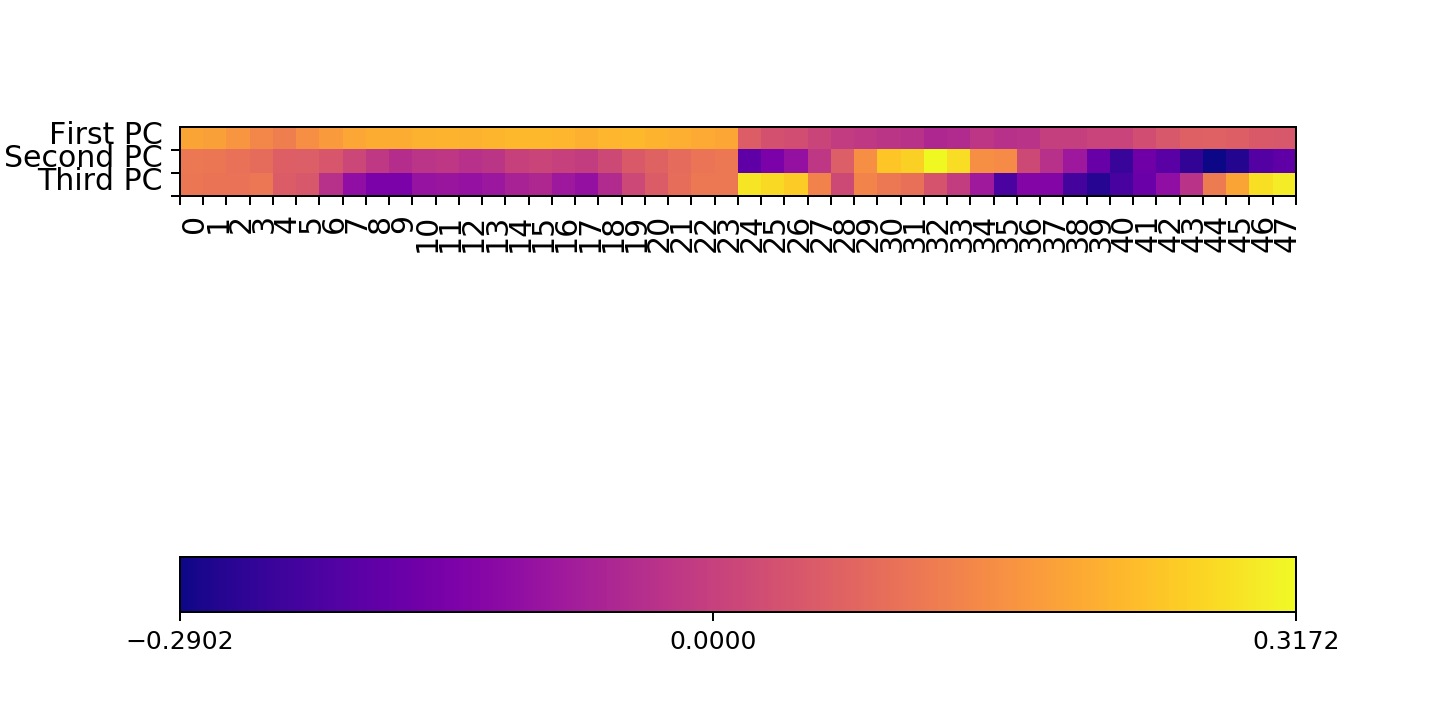

In [23]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

<IPython.core.display.Javascript object>


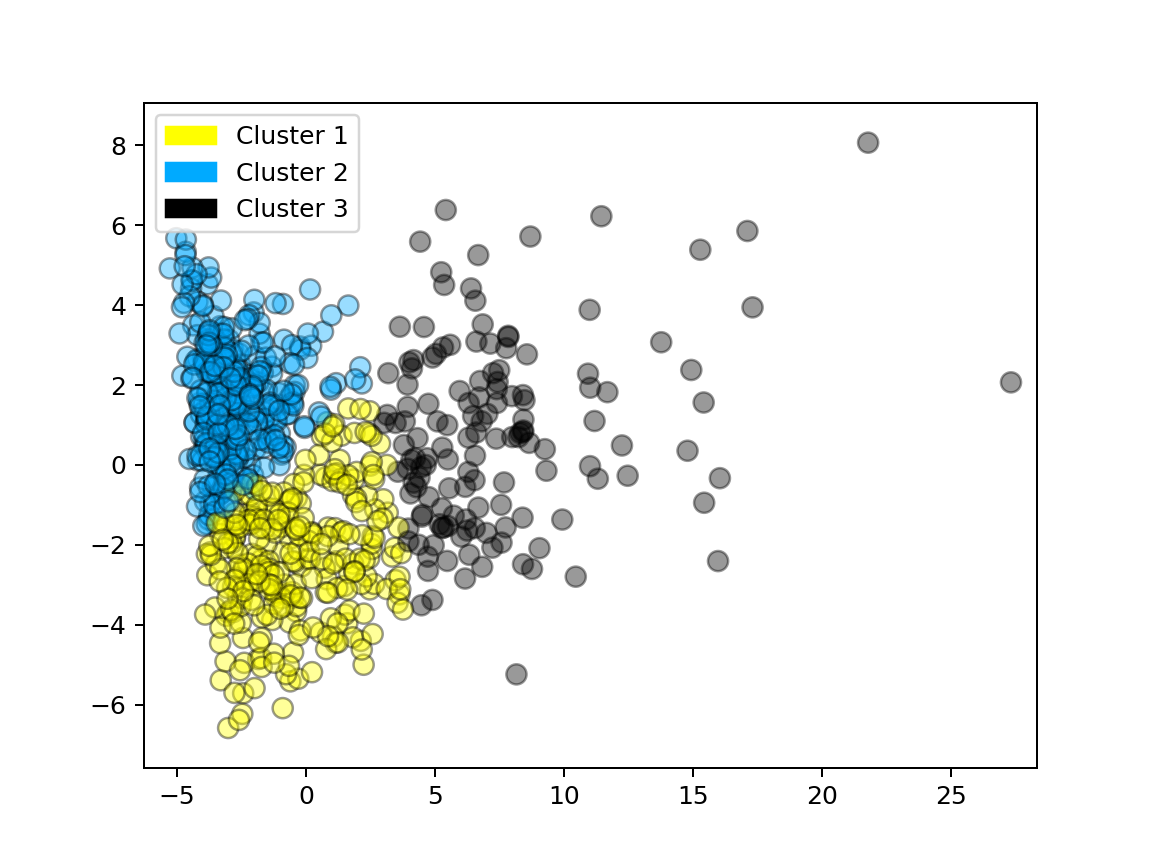

<IPython.core.display.Javascript object>


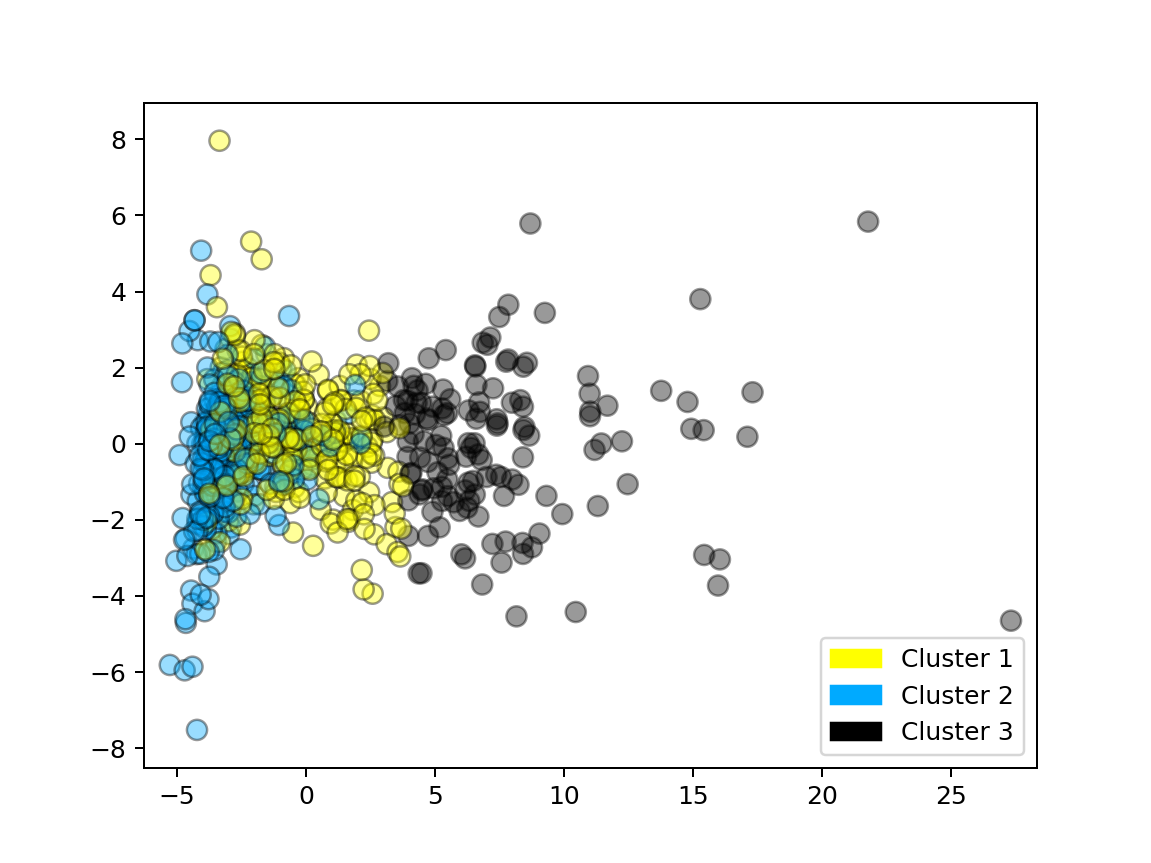

<IPython.core.display.Javascript object>


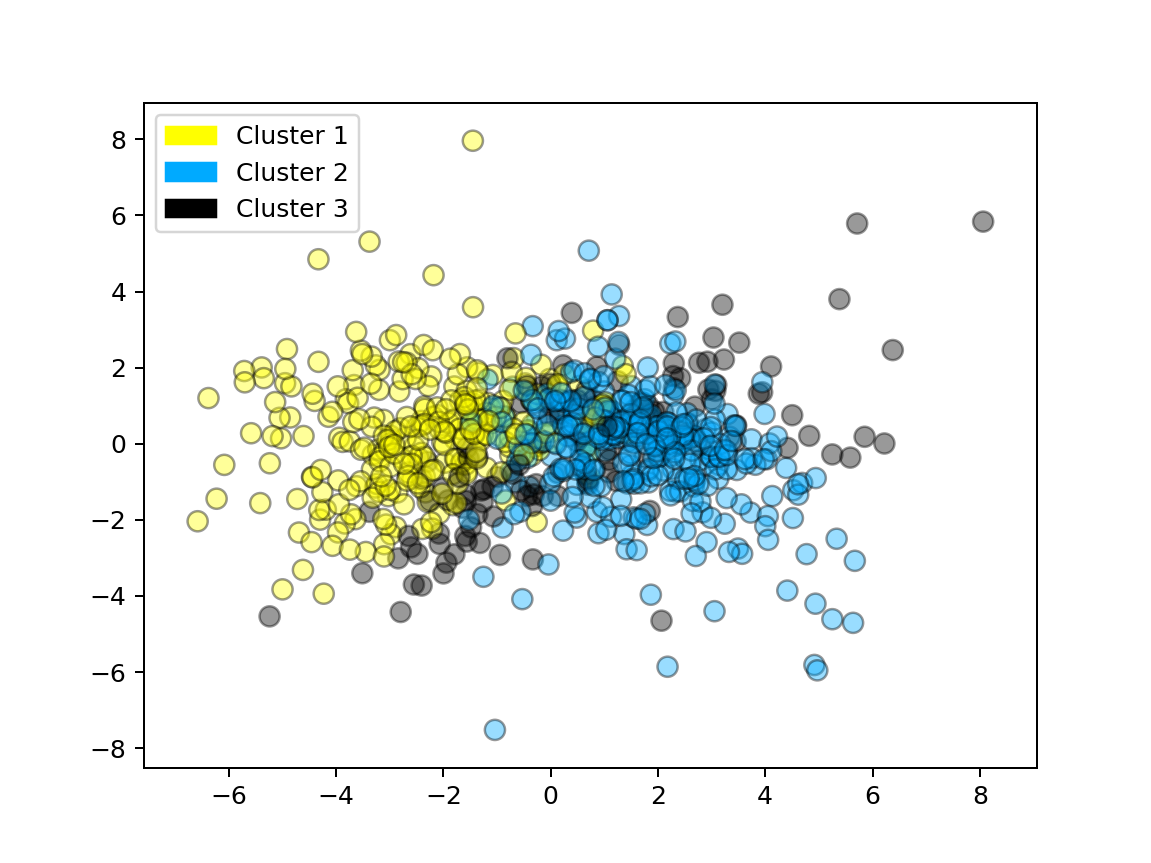

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (0,2))
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (1,2))

In [18]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)
    #plt.zlim(z_min, z_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

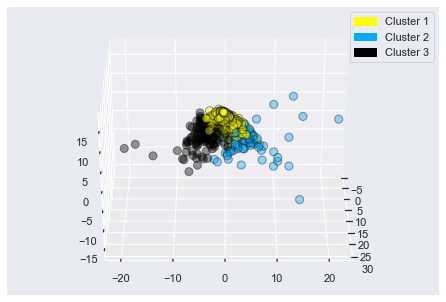

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [60]:
plot_3d_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])


In [27]:
WD_counts_df['KNN_label'] = kmeans.labels_

In [28]:
test_df=WD_counts_df[['norm_Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [29]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


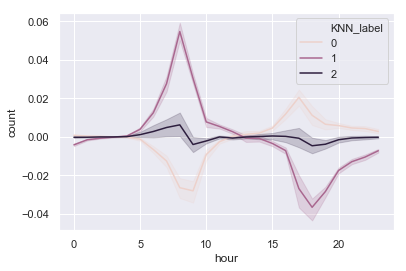

In [30]:
#Using norm_Flux 
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)

In [38]:
def color_st(x):
    if x == 0:
        return 'r'
    elif x == 1:
        return 'b'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'y'
    
stations_info_df['KNN_label'] = WD_counts_df['KNN_label']

stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

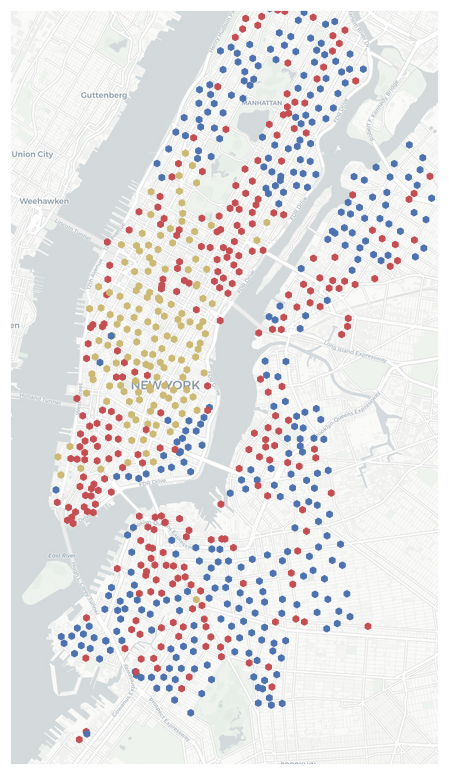

In [39]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)

## Now using Activity and Flux

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WD_counts_df[['Activity','Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 3).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(777, 48) (777, 3)


<IPython.core.display.Javascript object>


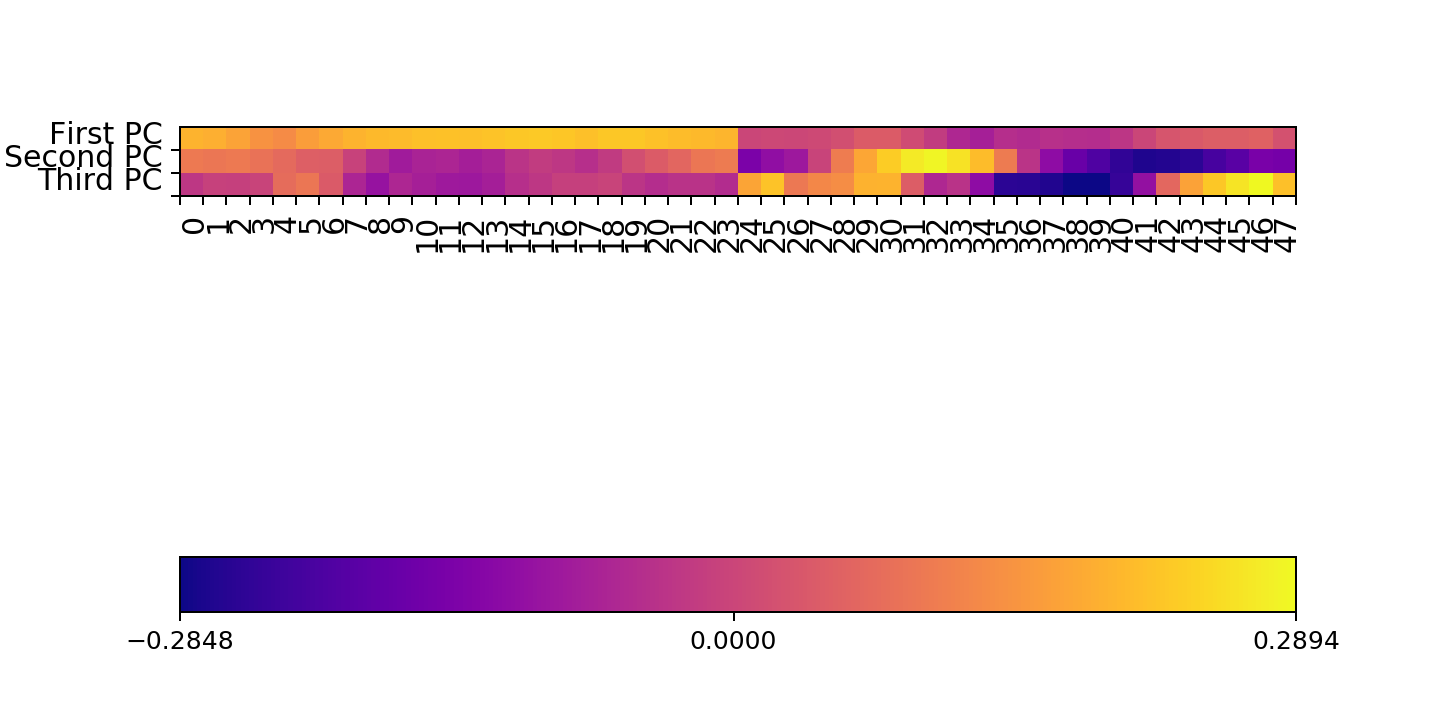

In [24]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

<IPython.core.display.Javascript object>


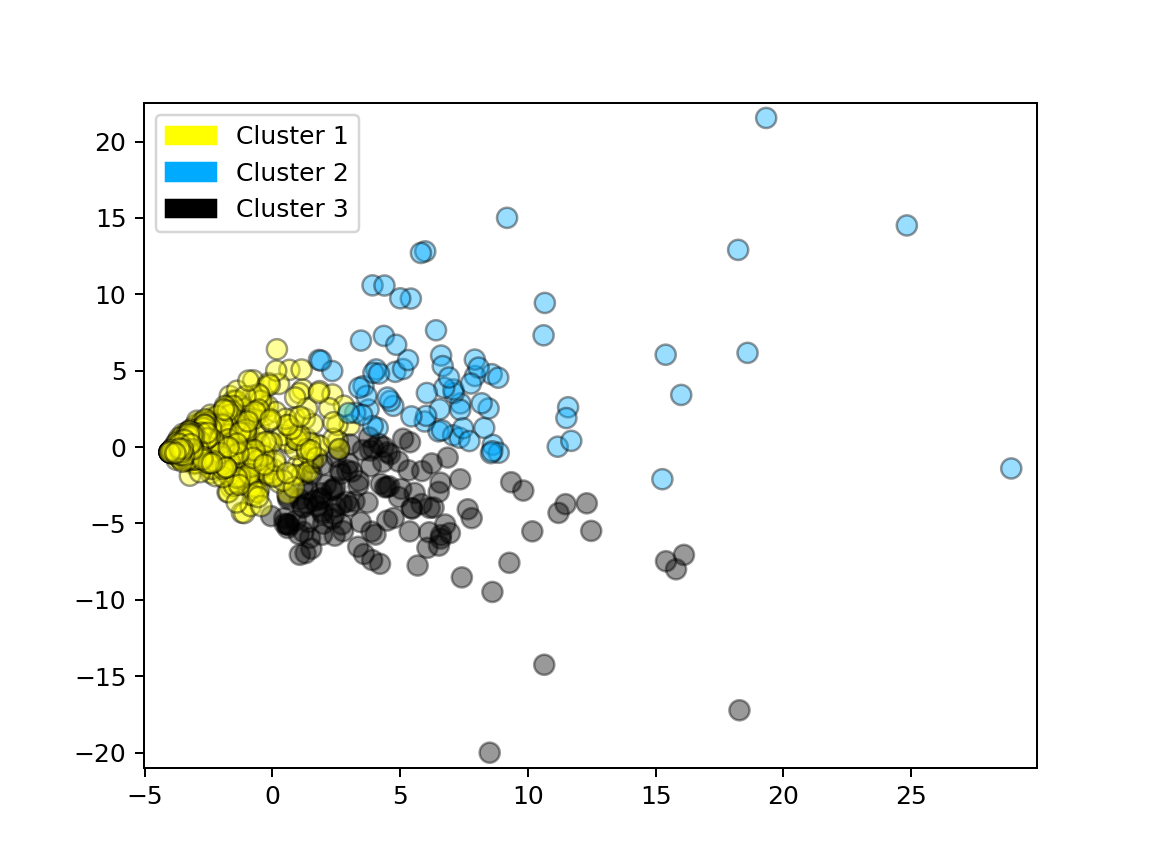

<IPython.core.display.Javascript object>


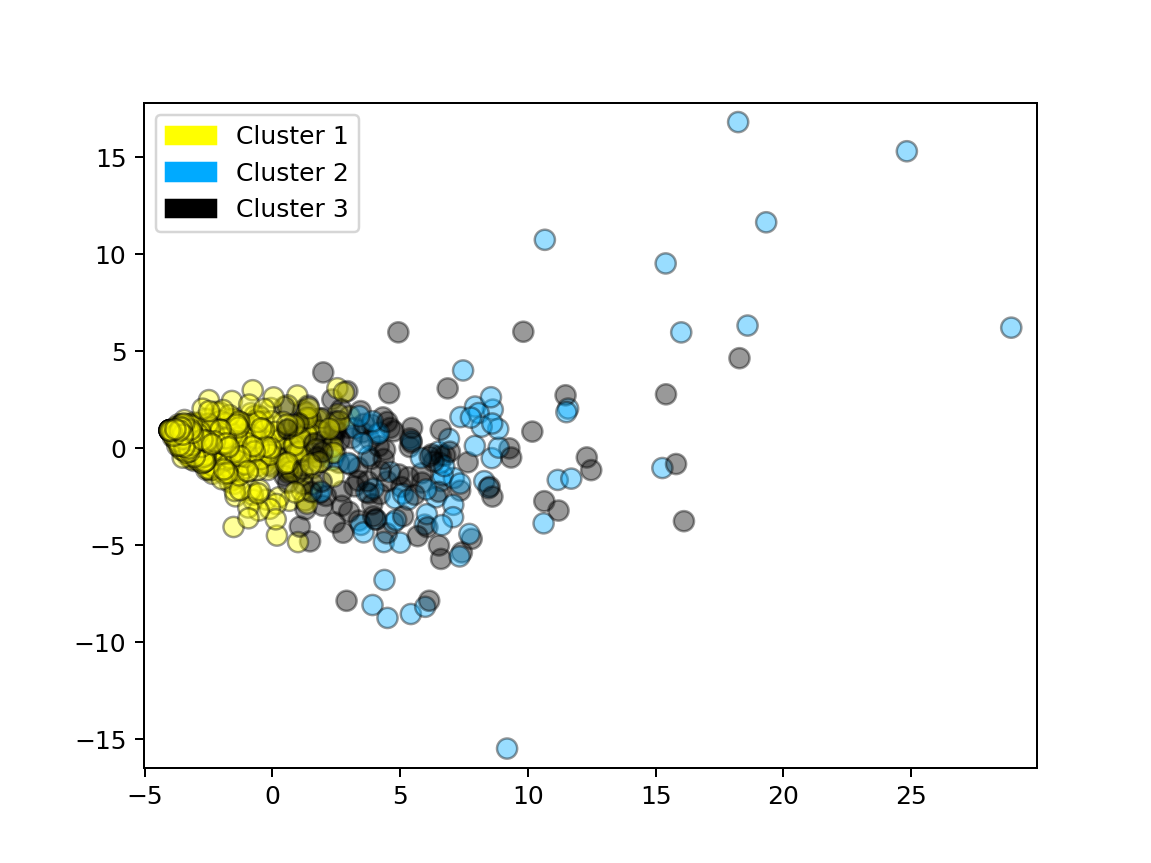

<IPython.core.display.Javascript object>


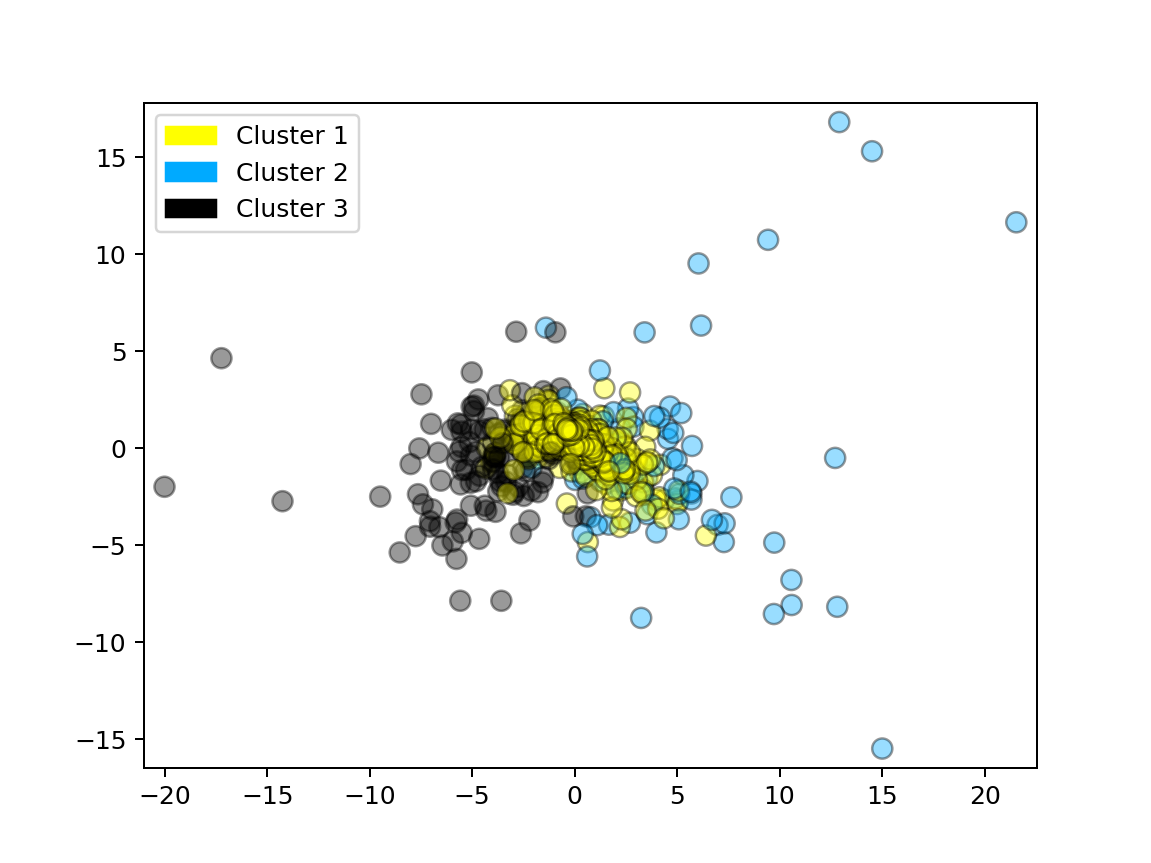

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (0,2))
plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (1,2))

<IPython.core.display.Javascript object>


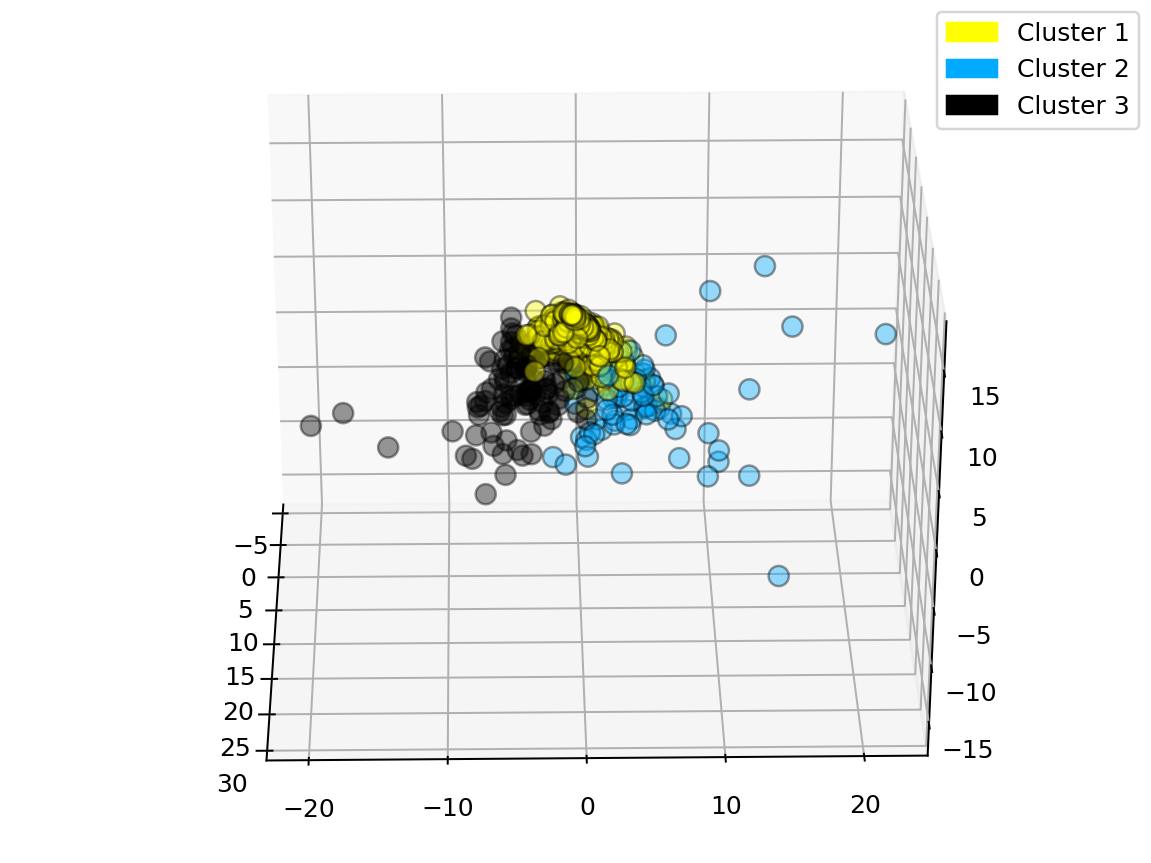

In [25]:
plot_3d_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

In [26]:
WD_counts_df['KNN_label'] = kmeans.labels_

Plotting Flux

In [27]:
test_df=WD_counts_df[['Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [28]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


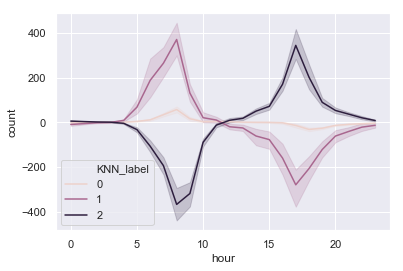

In [29]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


Plotting Activity

In [30]:
test_df=WD_counts_df[['Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [31]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

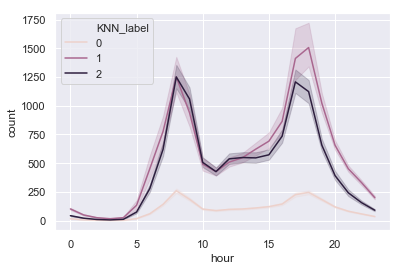

In [32]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


In [33]:
import tilemapbase
tilemapbase.start_logging()

In [34]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [35]:
t = tilemapbase.tiles.Carto_Light

In [36]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

In [37]:
len(WD_counts_df['KNN_label'])

777

In [38]:
stations_info_df['KNN_label'] = WD_counts_df['KNN_label']
#len(test_df.loc[24][1:].values)


In [39]:
def color_st(x):
    if x == 0:
        return 'r'
    elif x == 1:
        return 'b'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'y'

stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

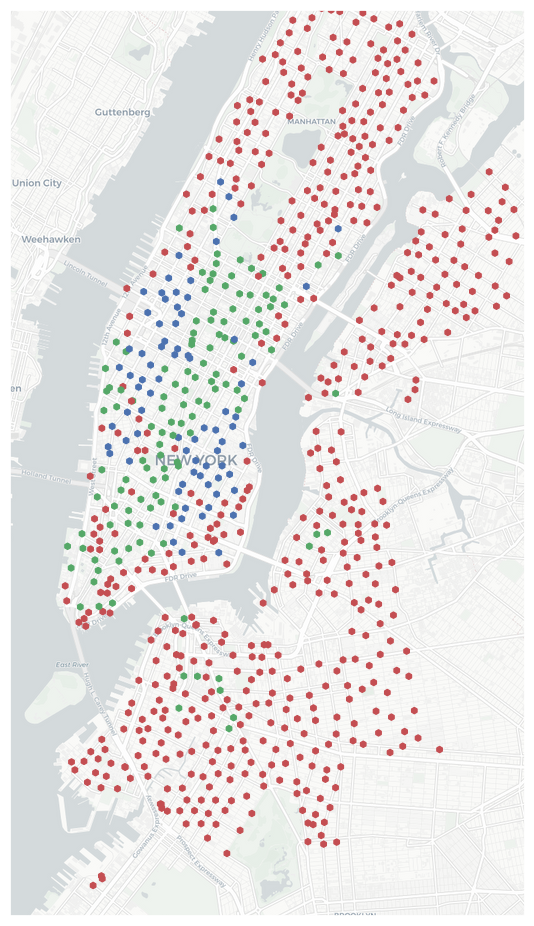

In [40]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);
   
#plt.annotate('hour = {}'.format(num), [x_cen,y_cen]);
#
#ax.set_title('Winter 2018, weekday dropoffs, hour = {}'.format(num))

#cax, _ = mpl.colorbar.make_axes(ax)
#cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
#cbar.ax.set_yticklabels(['0',  '{:.1f} per day'.format(WD_max_dropoff_cap/2/num_WD) , '> ' +  '{:.1f} per day'.format(WD_max_dropoff_cap/num_WD)])# vertically oriented colorbar

#plt.savefig('./Images/Winter_2018/Winter_2018_WD_drops_{}.png'.format(str(num)));
#plt.close()

In [91]:
WE_puhour_groupby = weekend_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WE_puhour_df = WE_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WE_dohour_groupby = weekend_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WE_dohour_df = WE_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [92]:
WE_counts_df = pd.concat([WE_puhour_df,WE_dohour_df],axis=1).fillna(0)
WE_counts_df['total_pickups'] = WE_counts_df['NumPickups'].sum(axis=1)
WE_counts_df['total_dropoffs'] = WE_counts_df['NumDropoffs'].sum(axis=1)

In [93]:
for num in range(24):
    WE_counts_df['NumCounts',num] =  WE_counts_df['NumPickups',num] + WE_counts_df['NumDropoffs',num] 
WE_counts_df['total_counts'] = WE_counts_df['NumCounts'].sum(axis=1)

In [94]:
WE_counts_df.sort_values('total_counts',ascending=False)

NumPickups                                                   \
pickup_hour          0     1     2     3     4     5     6     7      8   
435               21.0  20.0  14.0   3.0   4.0   3.0   3.0   9.0  144.0   
285               52.0  37.0  14.0   9.0   5.0   3.0  15.0  14.0   62.0   
497               36.0  30.0   7.0   7.0   6.0   4.0  11.0  20.0   46.0   
368               45.0  35.0  21.0  18.0  12.0   7.0  10.0  34.0   71.0   
459               19.0  18.0   1.0   2.0   1.0   1.0   0.0  13.0   30.0   
504               82.0  40.0  26.0  27.0  11.0   8.0  28.0  48.0  113.0   
284               27.0  28.0  25.0  12.0   9.0   1.0  15.0  42.0   63.0   
3435              30.0  16.0   6.0   5.0   3.0  10.0  25.0  34.0   50.0   
402               24.0  18.0   5.0   3.0   3.0   3.0   3.0   7.0   32.0   
229               24.0  24.0  15.0   9.0   2.0   1.0   1.0  20.0   46.0   
293               28.0  25.0  17.0  11.0   8.0   2.0   3.0  13.0   32.0   
3263              45.0  30.0  16.0  19.0   9.0   1.0   8.0  10.0   42.0   
432               53.0  17.0  15.0  19.0  12.0  18.0  13.0  15.0  116.0   
499               47.0  14.0  11.0   4.0  22.0   1.0   8.0  21.0   49.0   
382               22.0  21.0  15.0  11.0   7.0   4.0   3.0  15.0   48.0   
380               95.0  44.0  34.0  14.0  12.0   6.0   5.0  17.0   67.0   
438               31.0  39.0  16.0  14.0   4.0   2.0  16.0  15.0   49.0   
483               36.0  20.0  16.0   8.0   6.0   1.0   2.0   7.0   35.0   
151               22.0  27.0  14.0   9.0   4.0   4.0   3.0  29.0   42.0   
509               17.0   3.0   2.0   6.0   4.0   3.0   5.0  53.0  135.0   
168               28.0  24.0   4.0   1.0   4.0   0.0   3.0   6.0   17.0   
237               45.0  46.0  22.0  14.0   7.0   1.0   3.0  44.0   55.0   
439               49.0  40.0  25.0  24.0   9.0   6.0  32.0  38.0   48.0   
236               63.0  40.0  21.0  21.0   9.0   1.0   3.0  32.0   32.0   
326               31.0  22.0   7.0   5.0   5.0   0.0   3.0  23.0   52.0   
453               16.0  10.0  11.0  15.0   5.0  10.0   8.0  48.0  117.0   
446               25.0  11.0   7.0   4.0   4.0   1.0   5.0  28.0   52.0   
297               29.0  15.0  14.0   8.0   5.0   0.0   3.0  13.0   60.0   
358               18.0  15.0   3.0   7.0   2.0   5.0   6.0  24.0   96.0   
445               23.0  24.0  13.0  12.0   0.0   3.0  10.0  27.0   48.0   
...                ...   ...   ...   ...   ...   ...   ...   ...    ...   
3674               0.0   2.0   0.0   0.0   0.0   0.0   1.0   0.0    2.0   
3586               0.0   1.0   0.0   0.0   0.0   0.0   0.0   2.0    2.0   
3631               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    1.0   
3649               0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0   
3330               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
3492               1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0   
3596               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    2.0   
3505               0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0    2.0   
3394               0.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0    1.0   
3395               0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0    1.0   
3606               1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    3.0   
3333               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
3557               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
3559               0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0    1.0   
3620               1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0   
3647               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
3299               0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0    0.0   
3669               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
3564               0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0    0.0   
3512               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    1.0   
2005               0.0   0.0   0.0   

In [89]:
stations_info_df.loc[435]

lat                     40.7417
lon                    -73.9942
station name    W 21 St & 6 Ave
Name: 435, dtype: object

In [104]:
len(WD_counts_df.index)

779

In [102]:
len(stations_info_df)

772

In [108]:
WD_counts_df.iloc[WD_counts_df.index > 3503]

NumPickups                                                      \
pickup_hour          0     1     2     3     4     5      6      7       8   
3504               9.0   4.0   0.0   0.0   0.0   5.0   19.0   40.0    19.0   
3505               0.0   1.0   0.0   0.0   7.0   4.0    1.0    3.0     9.0   
3506               1.0   1.0   0.0   0.0   0.0   2.0    5.0   13.0    13.0   
3507              15.0   3.0   0.0   1.0   3.0  10.0  165.0  283.0   266.0   
3508              24.0  18.0   1.0   0.0   2.0   2.0   16.0   36.0    72.0   
3509               5.0   2.0   0.0   1.0   0.0   1.0   11.0  164.0    64.0   
3510               5.0   0.0   1.0   0.0   0.0   0.0   33.0   58.0   112.0   
3511               2.0   0.0   0.0   0.0   0.0   2.0   12.0   19.0    43.0   
3512               0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0     0.0   
3513               2.0   0.0   3.0   1.0   3.0  19.0    0.0    4.0    13.0   
3514               1.0   1.0   0.0   0.0   0.0  18.0   16.0   39.0    39.0   
3515               0.0   0.0   0.0   0.0   0.0   0.0    6.0    8.0    50.0   
3516              16.0   4.0   2.0   4.0   0.0   2.0   20.0   95.0    34.0   
3517              17.0   0.0   0.0   2.0   0.0   1.0    0.0    7.0    46.0   
3518              10.0   7.0   1.0   1.0   2.0  15.0    5.0   12.0    71.0   
3520               5.0   2.0   0.0   0.0   0.0   1.0   15.0   27.0    19.0   
3521              19.0   8.0   4.0   2.0   1.0   4.0   57.0   99.0   153.0   
3522               4.0   2.0   0.0   2.0   0.0   0.0   12.0   21.0    72.0   
3523               2.0   1.0   1.0   0.0   1.0   2.0    4.0   31.0    18.0   
3524               1.0   0.0   1.0   0.0   0.0   1.0   30.0   56.0   101.0   
3525               2.0   1.0   0.0   0.0   0.0   1.0    6.0   28.0     4.0   
3526              12.0   3.0   2.0   0.0   0.0   4.0    7.0   25.0    46.0   
3527               0.0   0.0   0.0   0.0   3.0   2.0    5.0   33.0    35.0   
3528               2.0   0.0   0.0   0.0   0.0   3.0    4.0    9.0    29.0   
3529               4.0   3.0   0.0   0.0   1.0   2.0   31.0  112.0    84.0   
3530               0.0   1.0   0.0   0.0   0.0  21.0    1.0   13.0    54.0   
3531               2.0   1.0   0.0   1.0  10.0  11.0   22.0   69.0    89.0   
3532               1.0   2.0   1.0   0.0   1.0   0.0   31.0   87.0    70.0   
3533               3.0   1.0   0.0   0.0   1.0   2.0   30.0    5.0    39.0   
3534              22.0   2.0   2.0   1.0   2.0  12.0   19.0  153.0   217.0   
...                ...   ...   ...   ...   ...   ...    ...    ...     ...   
3625               7.0   1.0   1.0   0.0   2.0   2.0    6.0    6.0    10.0   
3629               2.0   0.0   1.0   1.0   0.0   0.0    3.0    8.0    19.0   
3631               0.0   0.0   0.0   0.0   0.0   0.0    0.0    3.0     9.0   
3632              40.0  15.0  11.0  10.0  16.0  51.0  177.0  553.0  1261.0   
3635              23.0  10.0   2.0   4.0   6.0  44.0  164.0  333.0   381.0   
3637               6.0   8.0   1.0   1.0   2.0  10.0   29.0   83.0   256.0   
3641              24.0   9.0   4.0   4.0   1.0   9.0   63.0  209.0   339.0   
3642               0.0   0.0   0.0   0.0   0.0  12.0    8.0   30.0     9.0   
3643              14.0   1.0   1.0   1.0   0.0  15.0   61.0  211.0   415.0   
3644               5.0   2.0   0.0   0.0   0.0   1.0    1.0    7.0    21.0   
3646               2.0   0.0   0.0   0.0   1.0   0.0    1.0    5.0    12.0   
3647               0.0   0.0   0.0   0.0   0.0   0.0    7.0   24.0     0.0   
3648               2.0   1.0   7.0   1.0   0.0   1.0   24.0   85.0    98.0   
3649               1.0   1.0   0.0   1.0   0.0   0.0    0.0   10.0     9.0   
3650               0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0     5.0   
3653               3.0   0.0   4.0   4.0   0.0   6.0    5.0   23.0    61.0   
3654               2.0   0.0   0.0   1.0   0.0   3.0    1.0    5.0    30.0   
3656              44.0  13.0  11.0   7.0   1.0  30.0   74.0  252.0   621.0   
3658               6.0   6.0   5.0

In [115]:
len(stations_info_df.drop_duplicates('lat'))

772

In [114]:
len(stations_info_df)

772